In [1]:
import random

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sktime.utils.plotting import plot_series
from tensorflow.keras import layers, models, regularizers


SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [2]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [3]:
sequence_length = 4  # Número de trimestres na janela de tempo
test_size = 0.2
val_size = 0.2


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Income', 'Production', 'Savings', 'Unemployment', 'Consumption']])

def create_sequences(data, target_idx, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, target_idx=-1, seq_length=sequence_length)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

inputs = layers.Input(shape=(sequence_length, X.shape[2]))

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)  

outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.001))(x)
model = models.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 24 (96.00 B)

In [4]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - loss: 1.2090 - mae: 0.9570 - val_loss: 0.4123 - val_mae: 0.6136
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0417 - mae: 0.8899 - val_loss: 0.4071 - val_mae: 0.6097
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0121 - mae: 0.8598 - val_loss: 0.3985 - val_mae: 0.6029
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0528 - mae: 0.8832 - val_loss: 0.3866 - val_mae: 0.5933
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9649 - mae: 0.8541 - val_loss: 0.3751 - val_mae: 0.5836
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9346 - mae: 0.8203 - val_loss: 0.3616 - val_mae: 0.5721
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7896 - mae: 0.7629 - val_loss: 0.3484 - val_mae: 0.5606
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7636 - mae: 0.7531 - val_loss: 0.3346 - val_mae: 0.5483
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6951 - mae: 0.7135 -

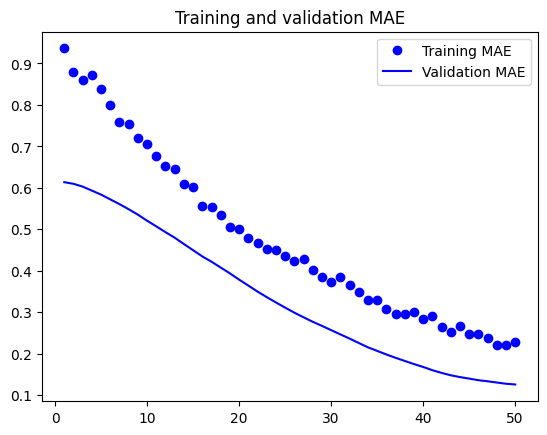

In [5]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Train, Test and Predictions'}, ylabel='y_train'>)

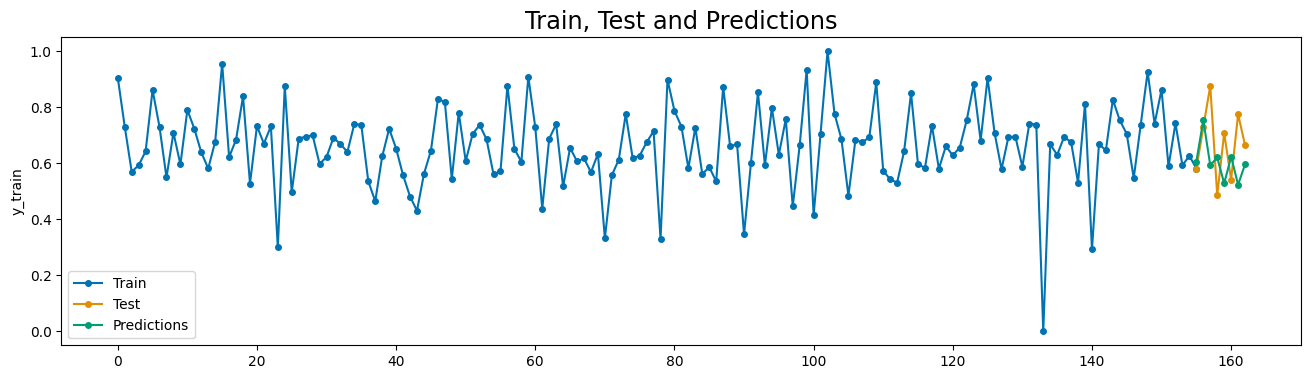

In [6]:
df_plot = pd.DataFrame()
df_plot.index = range(len(y_train) + len(y_test))

df_plot["y_train"] = np.nan
df_plot["y_test"] = np.nan
df_plot["y_pred"] = np.nan
df_plot.loc[:len(y_train)-1, "y_train"] = y_train
df_plot.loc[len(y_train):, "y_test"] = y_test
df_plot.loc[len(y_train):, "y_pred"] = model.predict(X_test).reshape(-1)

df_plot.loc[len(y_train), "y_train"] = df_plot.loc[len(y_train), "y_test"] # Connecting train and test plot lines


plot_series(
    df_plot["y_train"],
    df_plot["y_test"],
    df_plot["y_pred"],
    labels=["Train", "Test", "Predictions"],
    title="Train, Test and Predictions",
)

In [7]:
mae = mean_absolute_error(y_test, df_plot.loc[len(y_train):, "y_pred"])
rmse = np.sqrt(mean_squared_error(y_test, df_plot.loc[len(y_train):, "y_pred"]))

# MASE
naive_forecast = np.roll(y_train, 1)
naive_forecast[0] = y_train[0]
mae_naive = mean_absolute_error(y_train, naive_forecast)
mase = mae / mae_naive

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Scaled Error (MASE): {mase}")

Mean Absolute Error (MAE): 0.13129477089105937
Root Mean Squared Error (RMSE): 0.1608487932314788
Mean Absolute Scaled Error (MASE): 0.8284542690916485
